In [15]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import ipywidgets
from IPython.display import display, clear_output, Javascript, Markdown

import poisson_clustering as ps

In [16]:
circuits, cable_config, partial_discharges, warning = ps.load_data()
circ = circuits[4]
print(circ)
# Lengte van de kabel is gegeven in de cable config
cable_length = cable_config[circ]['Cumulative length (m)'].values[-1]
pardis = partial_discharges[circ]

2806


In [17]:
boolean_series, locations, charges, times, bins = ps.identify_suspicious_areas(pardis, cable_length)

In [18]:
clusters = ps.cluster_boolean_series(boolean_series)
print(clusters)

{(275, 282), (211, 229)}


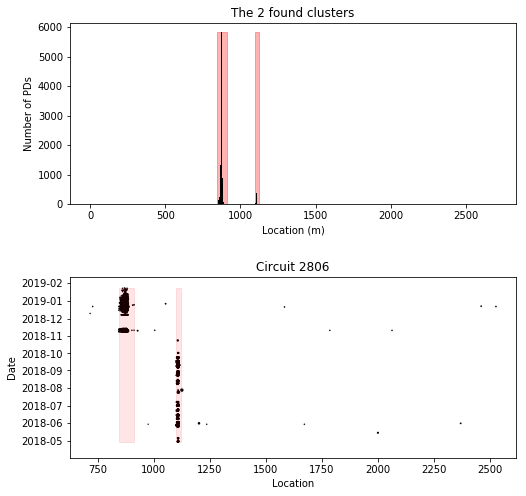

In [20]:
ps.show_plot(locations, times, charges, bins, clusters, circ)

In [21]:
def bin_times(cluster_pds, bin_size):
    time_column = cluster_pds.columns[0]
    convert_times = lambda s: datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S")
    cluster_times = cluster_pds[time_column].apply(convert_times)
    start_time = cluster_times[cluster_times.index[0]]
    stop_time = cluster_times[cluster_times.index[-1]]
    bins = np.arange(start = start_time, stop = stop_time, step = bin_size)
    binned_pds, _ = np.histogram(cluster_times, bins=bins)
    return binned_pds, bins
    
def time_clustering(partial_discharges, clusters, bin_size = datetime.timedelta(days=1)):
    time_column, location_column, charge_column = partial_discharges.columns
    pd_occurred = ~np.isnan(partial_discharges[location_column])
    pardis = partial_discharges[pd_occurred]
    
    result = []
    
    for cluster in clusters:
        xmin = cluster[0]
        xmax = cluster[1]
        
        in_cluster = [xmin <= loc <= xmax for loc in pardis[location_column]]
        cluster_pds = pardis[in_cluster]
        
        binned_pds, bins = bin_times(cluster_pds, bin_size)
        average = np.mean(binned_pds)
        
        boolean_pds_fault = binned_pds > average
        result.append((cluster, bins, boolean_pds_fault))
    return result

In [22]:
real_pds = pardis[~np.isnan(pardis[pardis.columns[1]])]
clusters_meters = {(x[0]*4, x[1]*4) for x in clusters}
cluster = clusters_meters.pop()
clusters_meters.add(cluster)
xmin = cluster[0]
xmax = cluster[1]
in_cluster = [xmin <= loc <= xmax for loc in real_pds[real_pds.columns[1]]]
cluster_pds = real_pds[in_cluster]
start_time = cluster_pds[cluster_pds.columns[0]][cluster_pds.index[0]]
end_time = cluster_pds[cluster_pds.columns[0]][cluster_pds.index[-1]]
convert_time = lambda s: datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S")
start_time = convert_time(start_time)
end_time = convert_time(end_time)
bins = np.arange(start = start_time, stop = end_time, step = datetime.timedelta(days=1))
cluster_times = cluster_pds[cluster_pds.columns[0]]
cluster_times = cluster_times.apply(convert_time)
binned_pds, _ = np.histogram(cluster_times, bins=bins)
binned_pds

array([ 373, 1235, 1055,  272,   91,   53,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   74,   43,    0,    0,
          0,    0,   70,   67,  153,   13,  216,  672,  343,  522,  747,
        689,  671,  398,  302,  315,  453,  397,  412,  217,  162,   98,
        108,  347,  509,  254,  446,  167,   83,   49,   70,   38,   11,
         10,    3,    2,    3,    3,    1,    5,    3,    2,    1])

In [32]:
clusters_meters = {(x[0]*4, x[1]*4) for x in clusters}
cluster_timebooleans = time_clustering(pardis, clusters_meters)
cluster_times = []
for cur in cluster_timebooleans:
    boolean_series = cur[2]
    clusters_cur = ps.cluster_boolean_series(boolean_series)
    cluster_times.append((cur[0], cur[1], clusters_cur))

time_location_clusters = []
for clt in cluster_times:
    for indices in clt[2]:
        imin = indices[0]
        tmin = clt[1][imin]
        imax = indices[1]
        tmax = clt[1][imax]
        time_location_clusters.append((clt[0], (tmin, tmax)))
time_location_clusters

[((844, 916),
  (numpy.datetime64('2018-12-16T14:19:00.000000'),
   numpy.datetime64('2019-01-07T14:19:00.000000'))),
 ((844, 916),
  (numpy.datetime64('2018-11-07T14:19:00.000000'),
   numpy.datetime64('2018-11-11T14:19:00.000000'))),
 ((1100, 1128),
  (numpy.datetime64('2018-09-05T14:53:00.000000'),
   numpy.datetime64('2018-09-17T14:53:00.000000'))),
 ((1100, 1128),
  (numpy.datetime64('2018-05-25T14:53:00.000000'),
   numpy.datetime64('2018-05-28T14:53:00.000000'))),
 ((1100, 1128),
  (numpy.datetime64('2018-08-27T14:53:00.000000'),
   numpy.datetime64('2018-08-30T14:53:00.000000')))]